<h1><center><font size="6">工程实践：TalkingData AdTracking EDA</font></center></h1>
<h2><center><font size="5">Light GBM模型的实现</font></center></h2>

# <a id='0'>目录</a>

- <a href='#1'>模型v1介绍</a>  
- <a href='#2'>载入包</a>  
- <a href='#2'>参数设置</a>  
- <a href='#3'>读入数据</a>
- <a href='#6'>特征工程</a>
    - <a href='#62'>派生特征工程</a>
- <a href='#7'>LGBM模型</a>  
    - <a href='#71'>模型定义</a>  
    - <a href='#71'>训练模型并保存模型</a> 
- <a href='#8'>预测及产生submission</a>


# <a id="1">模型v1介绍</a>

- 特征选取：
- 模型参数：
- 模型评估：
- 预测结果：


# <a id="2">载入包</a>

在这里，我们加载库并设置一些参数。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlcrate as mlc
import os
import gc # memory 
from datetime import datetime # train time checking

pd.set_option('display.max_columns', 100)

# <a id="3">参数设置</a>

这里我们设置了这个Notebook中使用的大多数参数。



In [2]:
RANDOM_STATE = 2018

#读取训练集
skiprows = range(1,109903891) #
nrows = 1000000

#取训练集子集
SAMPLE_SIZE = 1 # use a subsample of the train set

PATH = '../input/talkingdata_adtracking_fraud_detection/'
print(os.listdir(PATH))

['.DS_Store', 'test.csv', 'train_sample.csv', 'test_supplement.csv', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


# <a id="3">读入数据</a>

我们使用** Parameters **部分中设置的选项读取数据。


In [3]:
#设置读取相应列数据类型
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

#设置读入哪些列，降低内存消耗
train_cols = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

#使用train时，利用抽样取样，跳行skiprows，取nrows条数据
trainset = pd.read_csv(PATH+"train.csv", parse_dates=['click_time'], skiprows=skiprows, nrows=nrows,dtype=dtypes, usecols=train_cols)
trainset = trainset.sample(frac=SAMPLE_SIZE)


In [4]:
print("train -  rows:",trainset.shape[0]," columns:", trainset.shape[1])

train -  rows: 1000000  columns: 7


In [5]:
trainset.head()

,ip,app,device,os,channel,click_time,is_attributed
85978,102897,28,1,19,135,2017-11-08 12:35:03,0
318367,106200,12,1,15,245,2017-11-08 12:39:06,0
189684,59962,14,1,13,379,2017-11-08 12:36:49,0
102739,275930,18,1,19,121,2017-11-08 12:35:20,0
142699,88053,3,1,13,130,2017-11-08 12:36:01,0


In [6]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(trainset)

,Total,Percent
is_attributed,0,0.0
click_time,0,0.0
channel,0,0.0
os,0,0.0
device,0,0.0
app,0,0.0
ip,0,0.0


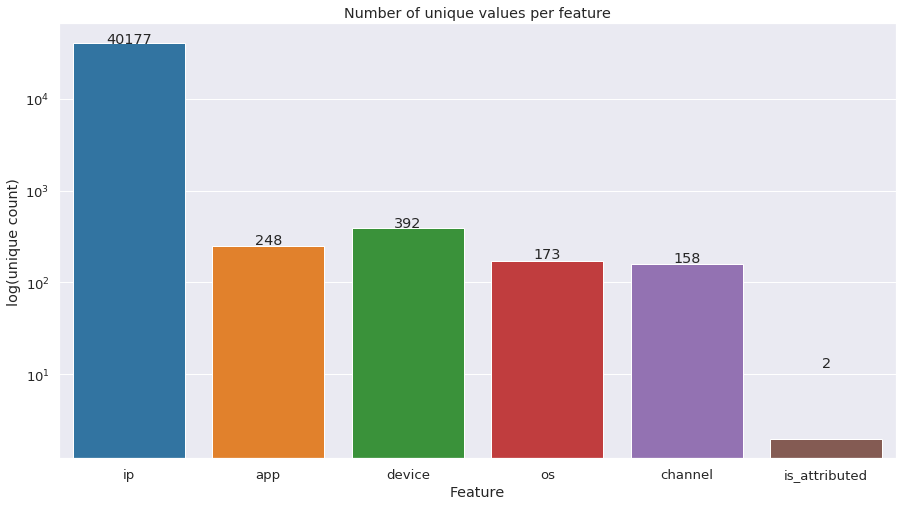

In [7]:
pal = sns.color_palette()
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed']
uniques = [len(trainset[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

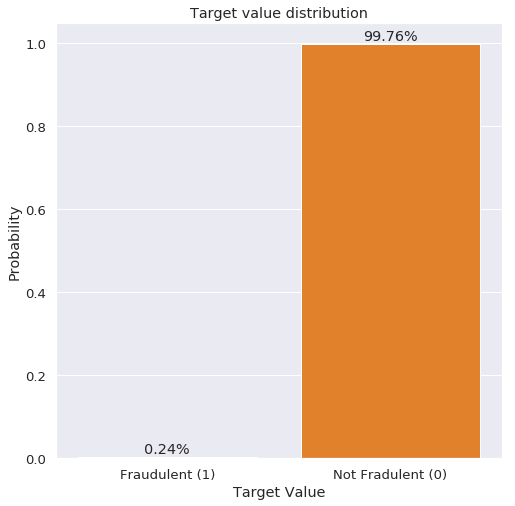

In [9]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (trainset.is_attributed.values == 1).mean()
ax = sns.barplot(['Fraudulent (1)', 'Not Fradulent (0)'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

In [10]:
trainset.describe()

,ip,app,device,os,channel,is_attributed
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,90438.079843,12.100961,17.448929,22.264450,273.023056,0.002432
std,68681.029471,16.325403,237.742996,53.345877,126.174892,0.049255
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39711.000000,3.000000,1.000000,13.000000,153.000000,0.000000
50%,78120.000000,12.000000,1.000000,18.000000,265.000000,0.000000
75%,116715.000000,15.000000,1.000000,19.000000,379.000000,0.000000
max,287533.000000,704.000000,3836.000000,777.000000,498.000000,1.000000


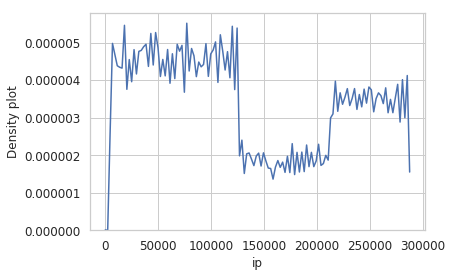

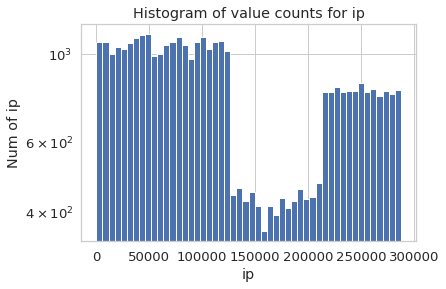

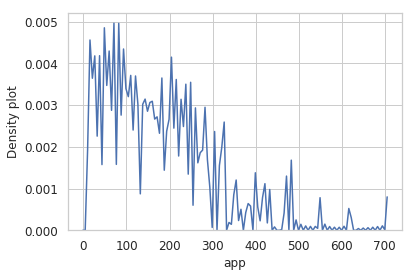

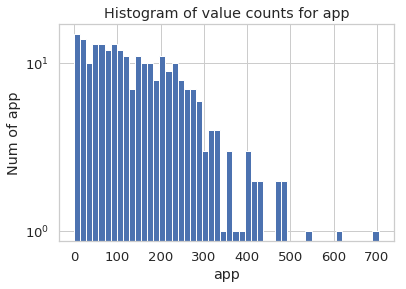

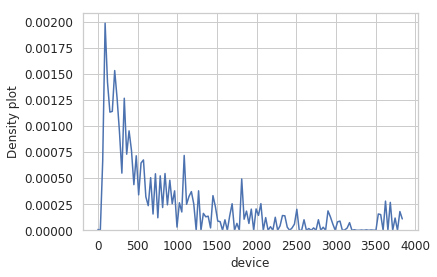

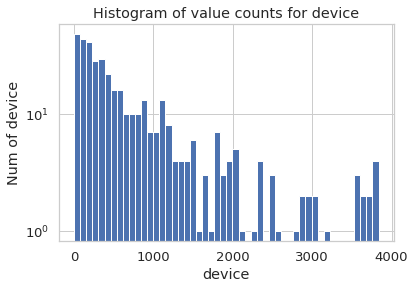

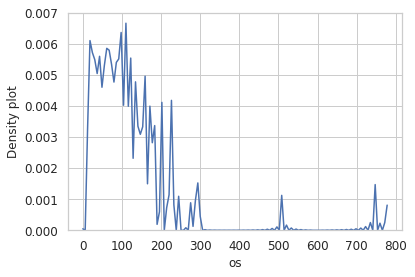

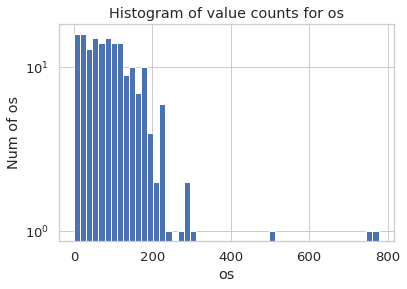

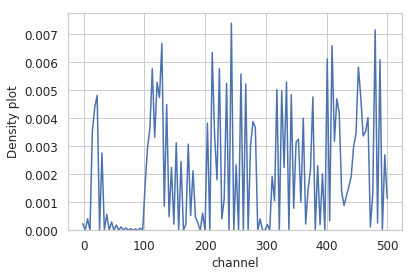

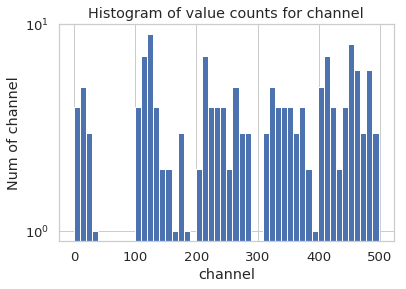

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


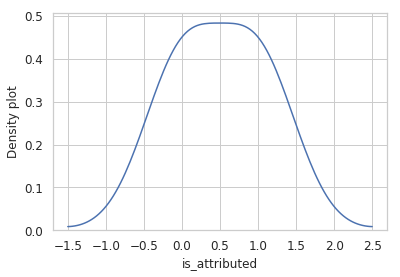

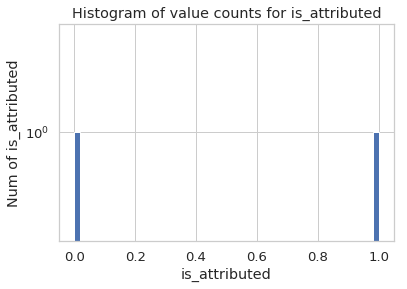

In [11]:
for col, uniq in zip(cols, uniques):
    counts = trainset[col].value_counts()
    sns.set_style('whitegrid')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sns.kdeplot(counts.keys(), bw=0.5)
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(col, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(counts.keys(), bins=50)
    ax.set_yscale('log', nonposy='clip')
    plt.title("Histogram of value counts for {}".format(col))
    plt.ylabel('Num of {}'.format(col))
    plt.xlabel(col)
    plt.show()

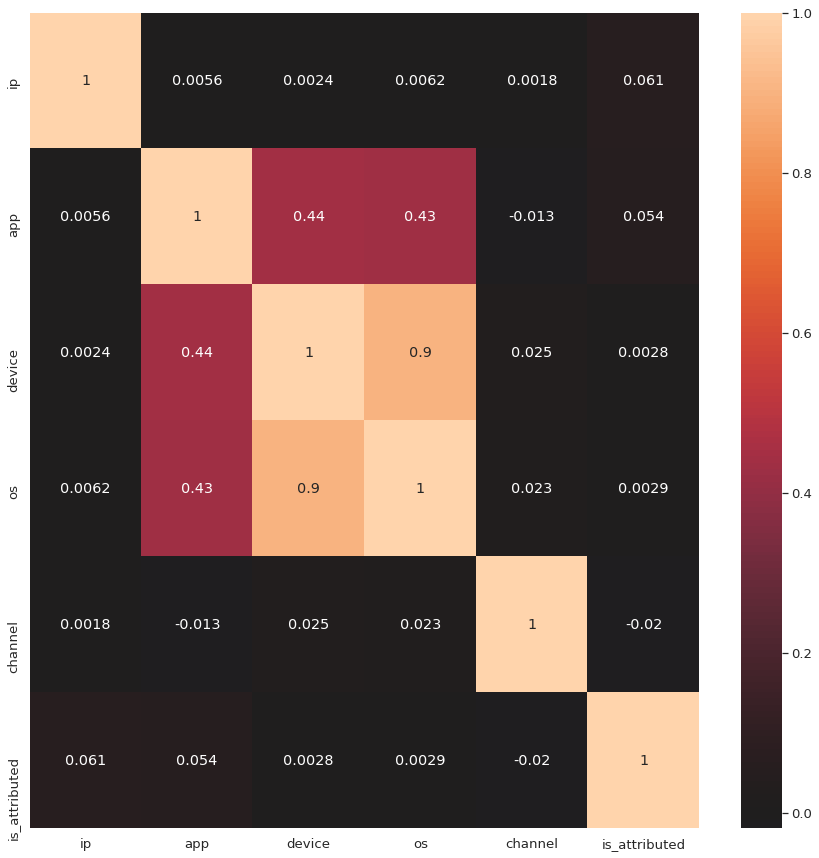

In [23]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(trainset.corr(), annot=True,center = 0 )
plt.show()

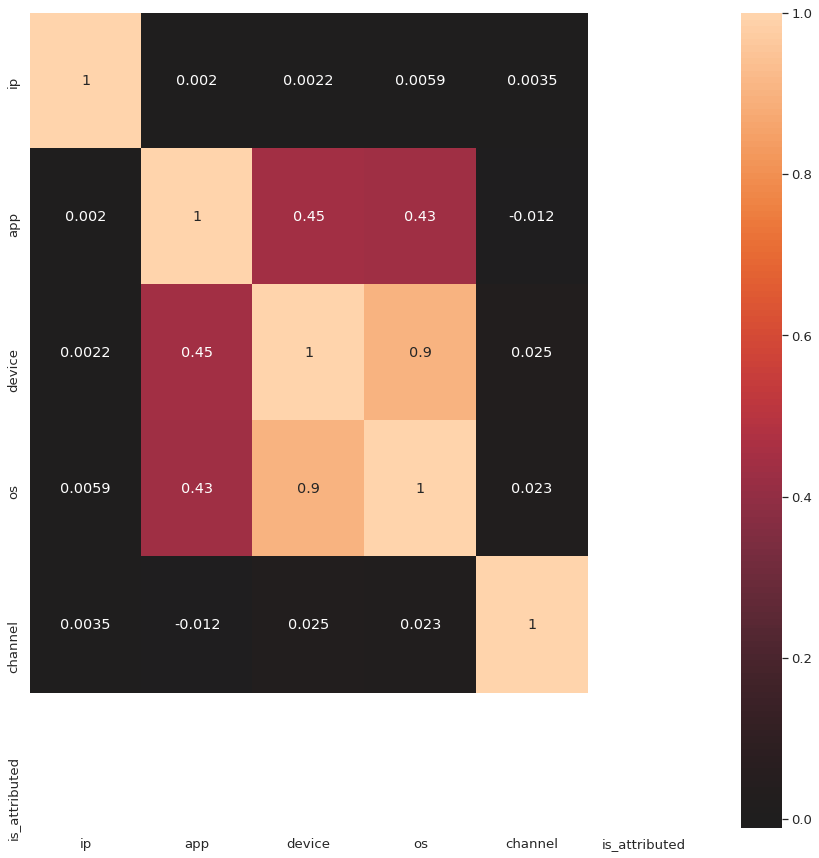

In [24]:
t0 = trainset.loc[trainset['is_attributed'] == 0]
plt.figure(figsize=(15, 15))
ax = sns.heatmap(t0.corr(), annot=True ,center = 0)
plt.show()

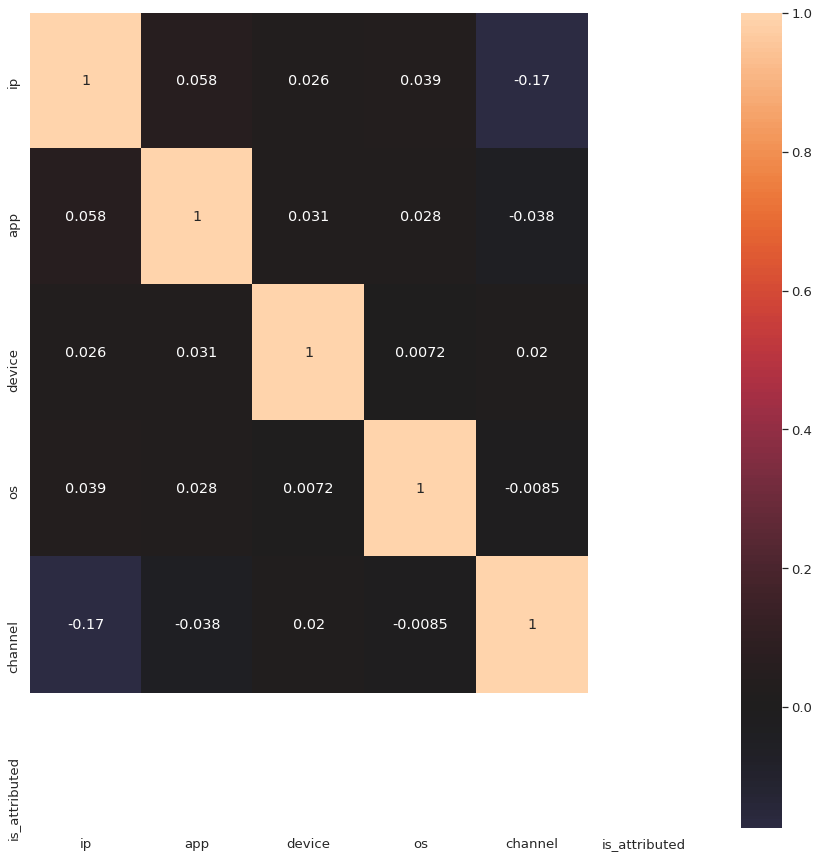

In [25]:
t1 = trainset.loc[trainset['is_attributed'] != 0]
plt.figure(figsize=(15, 15))
ax = sns.heatmap(t1.corr(), annot=True ,center = 0)
plt.show()

In [26]:
t0.describe()

,ip,app,device,os,channel,is_attributed
count,997568.000000,997568.000000,997568.000000,997568.000000,997568.000000,997568.0
mean,90231.728098,12.057656,17.415991,22.256853,273.145461,0.0
std,68477.908033,16.249001,237.871871,53.332551,126.203595,0.0
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,39611.000000,3.000000,1.000000,13.000000,153.000000,0.0
50%,77949.000000,12.000000,1.000000,18.000000,265.000000,0.0
75%,116501.750000,15.000000,1.000000,19.000000,379.000000,0.0
max,287533.000000,704.000000,3836.000000,777.000000,498.000000,0.0


In [28]:
t1.describe()

,ip,app,device,os,channel,is_attributed
count,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.0
mean,175080.307566,29.863898,30.959704,25.380757,222.814556,1.0
std,94692.587099,31.168469,176.661832,58.485434,102.107938,0.0
min,27.000000,0.000000,0.000000,0.000000,3.000000,1.0
25%,79131.750000,19.000000,0.000000,13.000000,115.750000,1.0
50%,222751.000000,19.000000,1.000000,19.000000,213.000000,1.0
75%,255693.250000,35.000000,1.000000,27.000000,274.000000,1.0
max,287466.000000,481.000000,3014.000000,748.000000,498.000000,1.0


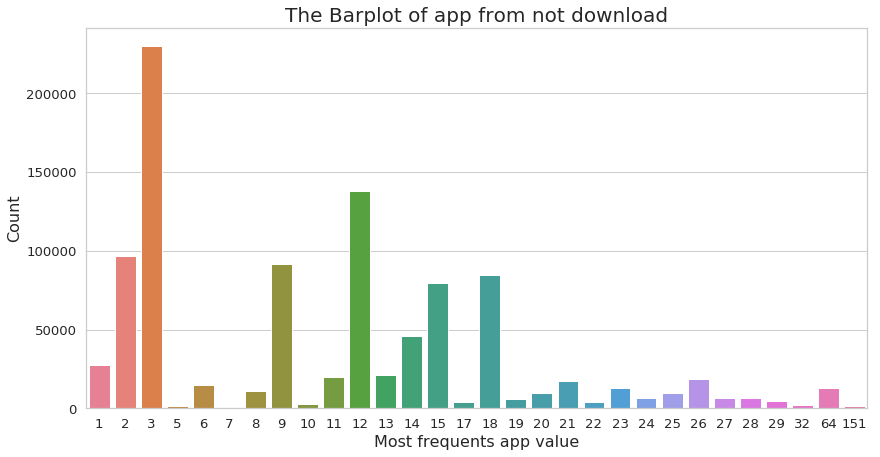

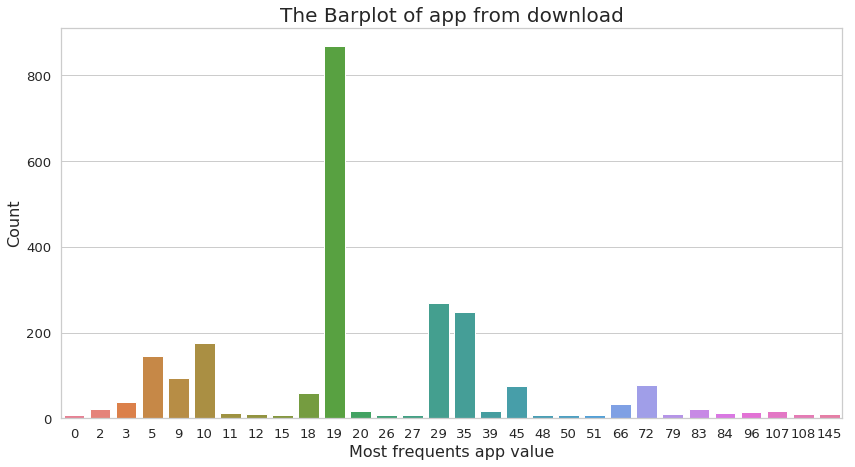

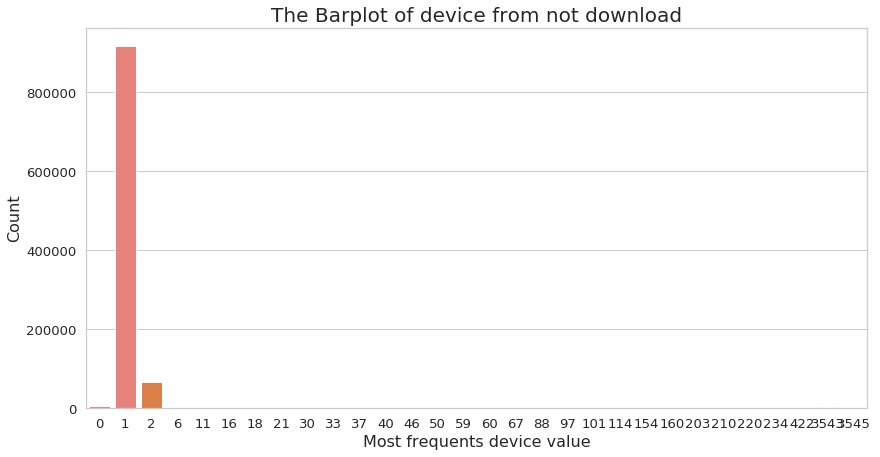

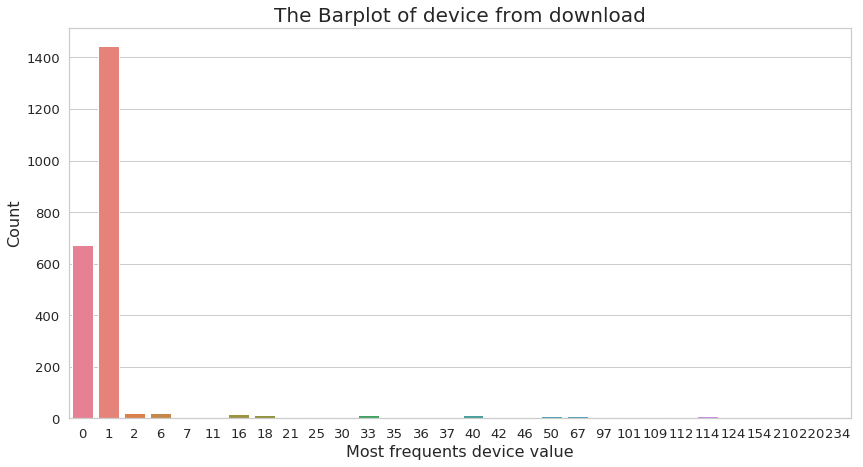

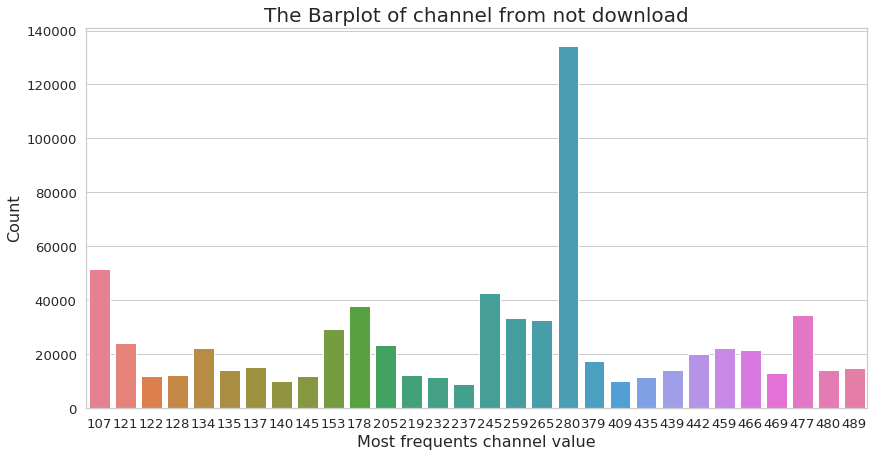

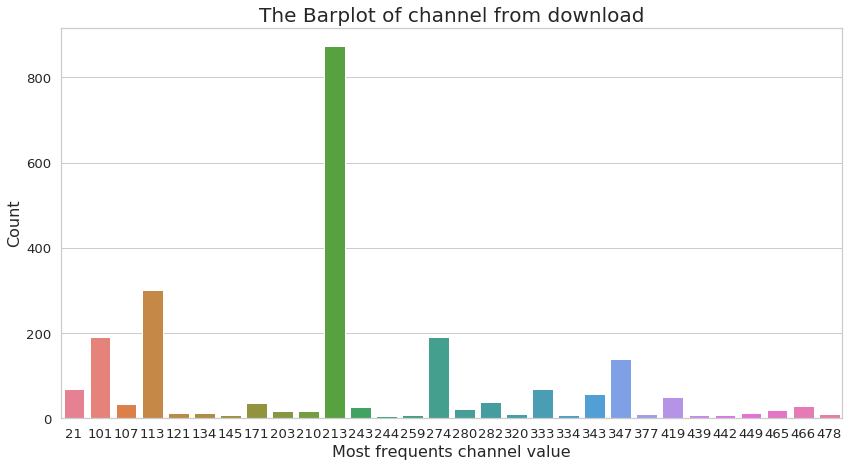

In [65]:
cols = ['app','device','channel']
for col in cols:
    counts1 = t0[col].value_counts().sort_values()[-30:]
    plt.figure(figsize=(14,7))
    plt.subplot(1,1,1)
    g = sns.barplot(counts1.keys(), counts1.values,
                    palette='husl')
    g.set_title("The Barplot of {} from not download".format(col),fontsize=20)
    g.set_xlabel('Most frequents {} value'.format(col),fontsize=16)
    g.set_ylabel('Count',fontsize=16)

    counts2 = t1[col].value_counts().sort_values()[-30:]
    plt.figure(figsize=(14,7))
    plt.subplot(1,1,1)
    g1 = sns.barplot(counts2.keys(), counts2.values,
                    palette='husl')
    g1.set_title("The Barplot of {} from download".format(col),fontsize=20)
    g1.set_xlabel('Most frequents {} value'.format(col),fontsize=16)
    g1.set_ylabel('Count',fontsize=16)
    
    plt.subplots_adjust(wspace = 0.1, hspace = 0.4,top = 0.9)
    plt.show()

# <a id="6">特征工程<a/>

## <a id="62">派生特征的工程</a>

定义用于计算派生特征的多个函数。

In [4]:
#------------------------------------------------------------------------------
#求agg_name特征中的最大值
def show_max_clean(df,gp,agg_name,agg_type,show_max):
#------------------------------------------------------------------------------    
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type,copy=False)
    gc.collect()
    return( df )
    
#------------------------------------------------------------------------------
#每个聚集（特征组合）的个数
def perform_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#每个group_cols中不同counted的个数
def perform_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Counting unique ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#计算每个聚集（特征组合）逐渐累加个数，（counted不起作用）
def perform_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#计算每个聚集（特征组合）中的counted平均值
def perform_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#计算每个聚集（特征组合）中的counted方差
def perform_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

In [5]:
def prep_data( df ):
    print('Extracting new features...')
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    gc.collect()
    
    # print('the Id of df before function: ',id(df))
    df = perform_countuniq( df, ['ip'], 'channel', 'X0', 'uint8', show_max=False ); gc.collect()
    df = perform_cumcount( df, ['ip', 'device', 'os'], 'app', 'X1', show_max=False ); gc.collect()
    # print('the Id of df after function: ',id(df)) # the same id with 'df' returned
    df = perform_countuniq( df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip'], 'app', 'X3', 'uint16', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip'], 'device', 'X5', 'uint16', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['app'], 'channel', 'X6','uint8', show_max=False ); gc.collect()
    df = perform_cumcount( df, ['ip'], 'os', 'X7', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip', 'device', 'os'], 'app', 'X8','uint8', show_max=False ); gc.collect()

    df = perform_countuniq( df, ['ip', 'device', 'os'], 'channel', 'A0', show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'app', 'channel'], 'A1', show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'device', 'os','app'], 'A2', show_max=False ); gc.collect()
    # ip-device-hour?

    df = perform_count( df, ['ip', 'day', 'hour'], 'ip_tcount','uint16',show_max=False ); gc.collect()
#     df = do_count( df, ['ip', 'hour'], 'ip_tcount2','uint32',show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'app'], 'ip_app_count','uint32', show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=False ); gc.collect()
    df = perform_var( df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=False ); gc.collect()
    df = perform_var( df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=False ); gc.collect()
    df = perform_var( df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=False ); gc.collect()
    df = perform_mean( df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=False ); gc.collect()

    print('doing nextClick 2...')
    df['click_time'] = (df['click_time'].astype(np.int64,copy=False) // 10 ** 9).astype(np.int32,copy=False)
    df['nextClick'] = (df.groupby(['ip', 'app', 'device', 'os']).click_time.shift(-1) - df.click_time).astype(np.float32,copy=False)
    df.drop(['click_time','day'], axis=1, inplace=True)
    gc.collect()
    return df
trainset = prep_data(trainset)
trainset.info()
gc.collect()

Extracting new features...
Counting unique  channel  by  ['ip'] ...
Cumulative count by  ['ip', 'device', 'os'] ...
Counting unique  hour  by  ['ip', 'day'] ...
Counting unique  app  by  ['ip'] ...
Counting unique  os  by  ['ip', 'app'] ...
Counting unique  device  by  ['ip'] ...
Counting unique  channel  by  ['app'] ...
Cumulative count by  ['ip'] ...
Counting unique  app  by  ['ip', 'device', 'os'] ...
Counting unique  channel  by  ['ip', 'device', 'os'] ...
Aggregating by  ['ip', 'app', 'channel'] ...
Aggregating by  ['ip', 'device', 'os', 'app'] ...
Aggregating by  ['ip', 'day', 'hour'] ...
Aggregating by  ['ip', 'app'] ...
Aggregating by  ['ip', 'app', 'os'] ...
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
Calculating variance of  day  by  ['ip', 'app', 'channel'] ...
Calculating mean of  hour  by  ['ip', 'app', 'channel'] ...
doing nextClick 2...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500000

14

# <a id="7">模型</a>

## <a id="71">模型的定义</a>

In [6]:
#设置lgb的参数
MAX_ROUNDS = 2000 #lgb iterations
EARLY_STOP = 50  #lgb early stop 
OPT_ROUNDS = 650  #To be adjusted based on best validation rounds
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'learning_rate': 0.2, # 【consider using 0.1】
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'scale_pos_weight': 200, # because training data is extremely unbalanced
        'num_leaves': 7,  # we should let it be smaller than 2^(max_depth), default=31
        'max_depth': 3,  # -1 means no limit, default=-1
        'min_data_per_leaf': 100,  # alias=min_data_per_leaf , min_data, min_child_samples, default=20
        'max_bin': 100,  # Number of bucketed bin for feature values,default=255
        'subsample': 0.7,  # Subsample ratio of the training instance.default=1.0, alias=bagging_fraction
        'subsample_freq': 1,  # k means will perform bagging at every k iteration, <=0 means no enable,alias=bagging_freq,default=0
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.alias:feature_fraction
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf),default=1e-3,Like min_data_in_leaf, it can be used to deal with over-fitting
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4, # should be equal to REAL cores:http://xgboost.readthedocs.io/en/latest/how_to/external_memory.html
        'verbose': 0
         }

target = 'is_attributed'
predictors = ['nextClick','app','device','os', 'channel', 'hour',
                  'ip_tcount', 'ip_tchan_count', 'ip_app_count',
                  'ip_app_os_count', 'ip_app_os_var',
                  'ip_app_channel_var_day','ip_app_channel_mean_hour',
                  'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
categorical = ['app', 'device', 'os', 'channel', 'hour']


## <a id="72">模型的训练</a>

train size:72500000
valid size:2500000
Training...
Training until validation scores don't improve for 50 rounds.
[10]	valid's auc: 0.861315
[20]	valid's auc: 0.958266
[30]	valid's auc: 0.963042
[40]	valid's auc: 0.965732
[50]	valid's auc: 0.966631
[60]	valid's auc: 0.967517
[70]	valid's auc: 0.967673
[80]	valid's auc: 0.967991
[90]	valid's auc: 0.968181
[100]	valid's auc: 0.968716
[110]	valid's auc: 0.968428
[120]	valid's auc: 0.97032
[130]	valid's auc: 0.970717
[140]	valid's auc: 0.970985
[150]	valid's auc: 0.971218
[160]	valid's auc: 0.971551
[170]	valid's auc: 0.971558
[180]	valid's auc: 0.971583
[190]	valid's auc: 0.971681
[200]	valid's auc: 0.971778
[210]	valid's auc: 0.971874
[220]	valid's auc: 0.971947
[230]	valid's auc: 0.971954
[240]	valid's auc: 0.971961
[250]	valid's auc: 0.971962
[260]	valid's auc: 0.972227
[270]	valid's auc: 0.972326
[280]	valid's auc: 0.972349
[290]	valid's auc: 0.972399
[300]	valid's auc: 0.972404
[310]	valid's auc: 0.972445
[320]	valid's auc: 0.972454
[

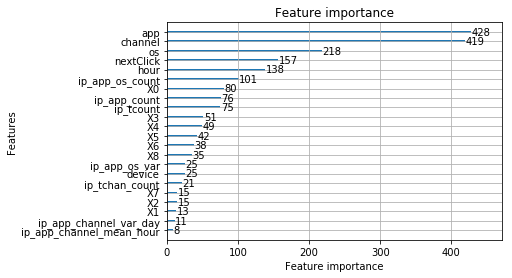

<Figure size 432x288 with 0 Axes>

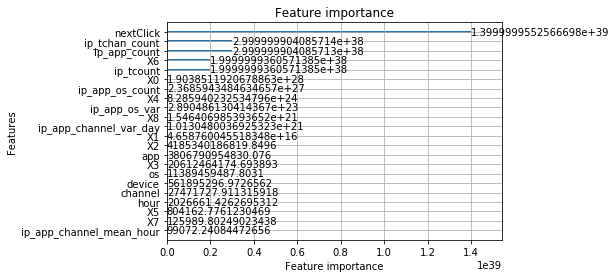

10041

<Figure size 432x288 with 0 Axes>

In [8]:
if VALIDATE:

    #train_df, val_df = train_test_split(trainset, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )
    train_df = trainset[:72500000]
    val_df = trainset[72500000:]
    print('train size:%d'%len(train_df))
    print('valid size:%d'%len(val_df))
    dtrain = lgb.Dataset(train_df[predictors].values, 
                         label=train_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical)
    del train_df
    gc.collect()

    dvalid = lgb.Dataset(val_df[predictors].values,
                         label=val_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical)
    del val_df
    gc.collect()

    evals_results = {}
    
    print("Training...")
    start_time = datetime.now()
    
    model = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dvalid], 
                      valid_names=['valid'], 
                      evals_result=evals_results, 
                      num_boost_round=MAX_ROUNDS,
                      early_stopping_rounds=EARLY_STOP,
                      verbose_eval=10, 
                      feval=None)
    del dtrain, dvalid
    gc.collect()
    print('[{}]: model training time'.format(datetime.now() - start_time))
    
elif VALIDATE_KFOLDS:
    kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)
    for train_index, test_index in kf.split(trainset):
        train_X, valid_X = trainset.iloc[train_index], trainset.iloc[test_index]
        
        dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                         feature_name=predictors, categorical_feature=categorical)
        del train_X
        gc.collect()
        
        dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                         feature_name=predictors, categorical_feature=categorical)
        del valid_X
        gc.collect()
        
        evals_results = {}
        
        print("Training...")
        start_time = datetime.now()
        model =  lgb.train(params, 
                      dtrain, 
                      valid_sets=[dvalid], 
                      valid_names=['valid'], 
                      evals_result=evals_results, 
                      num_boost_round=MAX_ROUNDS,
                      early_stopping_rounds=EARLY_STOP,
                      verbose_eval=10, 
                      feval=None)
        del dtrain, dvalid
        gc.collect()
        print('[{}]: model training time'.format(datetime.now() - start_time))
    
else:

    gc.collect()
    dtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
    del train_df
    gc.collect()

    evals_results = {}
    
    print("Training...")
    start_time = datetime.now()
    
    model = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain], 
                      valid_names=['train'], 
                      evals_result=evals_results, 
                      num_boost_round=OPT_ROUNDS,
                      verbose_eval=10,
                      feval=None)
    print('[{}]: model training time'.format(datetime.now() - start_time))

#画出特征重要性Importance以及划分后的信息增益Gain
print('Plot feature importances...')
lgb.plot_importance(model)
plt.show()
plt.gcf().savefig('feature_importance_runnablelightgbm_split.png')
lgb.plot_importance(model,importance_type='gain')
plt.show()
plt.gcf().savefig('feature_importance_runnablelightgbm_gain.png')

# dump model with pickle
with open('model_v3.pkl', 'wb') as fout:
    pickle.dump(model, fout)
gc.collect()

# <a id="8">预测及输出</a>

In [13]:
#读取测试集test
test_cols = ['ip','app','device','os', 'channel', 'click_time', 'click_id']
testset = pd.read_csv(PATH+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=test_cols)

#对测试集进行预处理
test_df = prep_data(testset)
gc.collect()

Extracting new features...
Counting unique  channel  by  ['ip'] ...
Cumulative count by  ['ip', 'device', 'os'] ...
Counting unique  hour  by  ['ip', 'day'] ...
Counting unique  app  by  ['ip'] ...
Counting unique  os  by  ['ip', 'app'] ...
Counting unique  device  by  ['ip'] ...
Counting unique  channel  by  ['app'] ...
Cumulative count by  ['ip'] ...
Counting unique  app  by  ['ip', 'device', 'os'] ...
Counting unique  channel  by  ['ip', 'device', 'os'] ...
Aggregating by  ['ip', 'app', 'channel'] ...
Aggregating by  ['ip', 'device', 'os', 'app'] ...
Aggregating by  ['ip', 'day', 'hour'] ...
Aggregating by  ['ip', 'app'] ...
Aggregating by  ['ip', 'app', 'os'] ...
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
Calculating variance of  day  by  ['ip', 'app', 'channel'] ...
Calculating mean of  hour  by  ['ip', 'app', 'channel'] ...
doing nextClick 2...


0

In [15]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id']
# load model with pickle to predict
with open('model_v3_09725.pkl', 'rb') as fin:
    model = pickle.load(fin)
print("Predicting...")
sub['is_attributed'] = model.predict(test_df[predictors])

print("writing...")
sub.to_csv('submission_v3.csv', index=False, float_format='%.9f')
del sub
gc.collect()
print("All done...")


Predicting...
writing...
All done...
